In [24]:
import json
from glob import glob
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools

In [25]:
INTENTS = [
     'FindAttraction',
     'FindRestaurants',
     'FindMovie',
     'LookUpMusic',
     'SearchHotel',
     'FindEvents'
]

In [26]:
def find_intent(raw):
     canonical_intents = {
          'findattraction': 'FindAttraction',
          'findrestaurant': 'FindRestaurants',
          'findrestaurants': 'FindRestaurants',
          'findmovie': 'FindMovie',
          'lookmusic': 'LookUpMusic',
          'lookupmusic': 'LookUpMusic',
          'searchhotel': 'SearchHotel',
          'findevent': 'FindEvents',
          'findevents': 'FindEvents'
     }
     cleaned = raw.lower().replace(" ", "").replace("_", "")
     for k in canonical_intents:
          if k in cleaned:
               return canonical_intents[k]
     return None

## Age Result Analysis
- 20 (random) personas
- 15 conversations each

In [27]:
age_result = []

for path in sorted(glob('/tmp2/b11902155/PersonSalesAgent/simulation_output/age_20/*.json')):
     with open(path, 'r') as f:
          data = json.load(f)

     age = Path(path).stem
     
     for p in data:
          success_rate = (sum(1 for reason in p['terminate_reason'] if reason == 'Success') /
                         len(p['terminate_reason']))
          average_turn = sum(x for x in p['num_turns']) / len(p['num_turns'])
          average_turn_w_success = np.mean([
               p['num_turns'][i]
               for i in range(len(p["num_turns"]))
               if p['terminate_reason'][i] == 'Success'
          ])
          continue_ratio_micro = (sum(1 for conv in p['conversations'].values() for c in conv if c['role'] == 'user' and 'I should continue the topic' in c.get('thought', '')) /
                                   sum(1 for conv in p['conversations'].values() for c in conv if c['role'] == 'user'))

          continue_ratio_macro = np.mean([
               sum(1 for c in conv if c['role'] == 'user' and 'I should continue the topic' in c.get('thought', '')) /
               sum(1 for c in conv if c['role'] == 'user')
               for conv in p['conversations'].values()
          ])

          intent_count = {intent: 0 for intent in INTENTS}
          intent_count_strict = {intent: 0 for intent in INTENTS}
          success_intent_count = {intent: 0 for intent in INTENTS}
          switch_count = 0
          switch_count_strict = 0
          switch_count_success = 0
          switch_count_strict_success = 0
          for i, conv in enumerate(p['conversations'].values()):
               success = p['terminate_reason'][i] == 'Success'
               switch_cnt_strict = 0
               last_intent = None
               last_intent_strict = None

               if success:
                    success_intent_count[find_intent(conv[-1]['thought'])] += 1
               
               for c in conv:
                    if c['role'] != 'user':
                         continue

                    intent = find_intent(c.get('thought', ''))
                    if c.get('thought', '').startswith('The user did not implicitly mention any potential intent, I should continue the chit-chat.'):
                         last_intent_strict = None
                    if intent is not None:
                         if last_intent is not None and intent != last_intent:
                              switch_count += 1
                              if success:
                                   switch_count_success += 1
                              intent_count[last_intent] += 1
                         last_intent = intent

                         if last_intent_strict is not None and intent != last_intent_strict:
                              switch_count_strict += 1
                              if success:
                                   switch_count_strict_success += 1
                              intent_count_strict[last_intent] += 1
                         last_intent_strict = intent
                         
               if last_intent is not None:
                    switch_count += 1
                    if success:
                         switch_count_success += 1
                    intent_count[last_intent] += 1
               if last_intent_strict is not None:
                    switch_count_strict += 1
                    if success:
                         switch_count_strict_success += 1
                    intent_count_strict[last_intent] += 1

          switch_count /= len(p['conversations'])
          switch_count_strict /= len(p['conversations'])
          switch_count_success /= sum(1 for msg in p['terminate_reason'] if msg == 'Success')
          switch_count_strict_success /= sum(1 for msg in p['terminate_reason'] if msg == 'Success')


          age_result.append({
               'age': age,
               'success rate': success_rate,
               'average turn': average_turn,
               'average turn w/ success': average_turn_w_success,
               'continue ratio micro': continue_ratio_micro,
               'continue ratio macro': continue_ratio_macro,
               'switch count': switch_count,
               'switch count strict': switch_count_strict,
               'switch count w/ success': switch_count_success,
               'switch count w/ success strict': switch_count_strict_success,
          }| {
               ('intent count', k): v
               for k, v in intent_count.items()
          } | {
               ('intent count strict', k): v
               for k, v in intent_count_strict.items()
          } | {
               ('success intent count', k): v
               for k, v in success_intent_count.items()
          })

age_df = pd.DataFrame.from_dict(age_result)
age_df.columns = pd.MultiIndex.from_tuples([
    (col, '') if not isinstance(col, tuple) else col for col in age_df.columns
])
age_df


age success rate average turn average turn w/ success  \
                                                                 
0   adult_20     0.733333    13.866667               11.636364   
1   adult_20     0.533333    16.000000               12.500000   
2   adult_20     0.733333    14.266667               12.181818   
3   adult_20     0.733333    15.333333               13.636364   
4   adult_20     0.666667    16.533333               14.800000   
..       ...          ...          ...                     ...   
75   teen_20     0.400000    14.666667                6.666667   
76   teen_20     0.733333    13.866667               11.636364   
77   teen_20     0.800000    14.266667               12.833333   
78   teen_20     0.400000    15.733333                9.333333   
79   teen_20     0.200000    17.333333                6.666667   

   continue ratio micro continue ratio macro switch count switch count strict  \
                                                                                
0              0.352941             0.284137     1.266667            1.266667   
1              0.511111             0.441578     1.466667            1.466667   
2              0.368852             0.295815     1.133333            1.133333   
3              0.346154             0.302184     1.466667            1.466667   
4              0.482014             0.447561     1.466667            1.400000   
..                  ...                  ...          ...                 ...   
75             0.552000             0.418182     1.600000            1.400000   
76             0.352941             0.288576     1.066667            1.066667   
77             0.336066             0.282169     1.466667            1.400000   
78             0.541353             0.452802     1.133333            1.066667   
79             0.558621             0.494372     1.333333            1.266667   

   switch count w/ success switch count w/ success strict  ...  \
                                                           ...   
0                 1.363636                       1.363636  ...   
1                 1.250000                       1.250000  ...   
2                 1.181818                       1.181818  ...   
3                 1.090909                       1.090909  ...   
4                 1.200000                       1.200000  ...   
..                     ...                            ...  ...   
75                1.833333                       1.833333  ...   
76                1.000000                       1.000000  ...   
77                1.166667                       1.166667  ...   
78                1.333333                       1.166667  ...   
79                1.666667                       1.666667  ...   

   intent count strict                                     \
             FindMovie LookUpMusic SearchHotel FindEvents   
0                    0           0           2          3   
1                    0           5           0          9   
2                    0           0           3          7   
3                    3           0           4         12   
4                    1           0           5          2   
..                 ...         ...         ...        ...   
75                   0           0          14          0   
76                   0           0           0          6   
77                   0           0           4          7   
78                   0           0           6          2   
79                   3           0           3          3   

   success intent count                                                    \
         FindAttraction FindRestaurants FindMovie LookUpMusic SearchHotel   
0                     0               8         0           0           1   
1                     0               3         0           2           0   
2                     1               3         0           0           3   
3                     0               1         1         

In [28]:
agg_dict = {}
for col in age_df.columns:
     if col[0] in ['age']:
          continue
     if col[0] in ['intent count', 'intent count strict', 'success intent count']:
          agg_dict[col] = 'sum'
     else:
          agg_dict[col] = 'mean'

age_agg_df = age_df.groupby('age', as_index=False).agg(agg_dict)
age_agg_df.set_index('age', inplace = True)
age_agg_df.to_csv('age_result.csv')

float_cols = age_df.select_dtypes(include='float').columns
format_dict = {col: "{:.2f}" for col in float_cols}

styled_age_agg_df = (
     age_agg_df.style
     .format(format_dict)
     .set_caption("Age Aggregated Results")
     .set_table_styles(
          [
               {
                    'selector': 'th.col_heading',
                    'props': 'border: 2px solid black;'
               }
          ]
     )
)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
     display(styled_age_agg_df)


### Plot

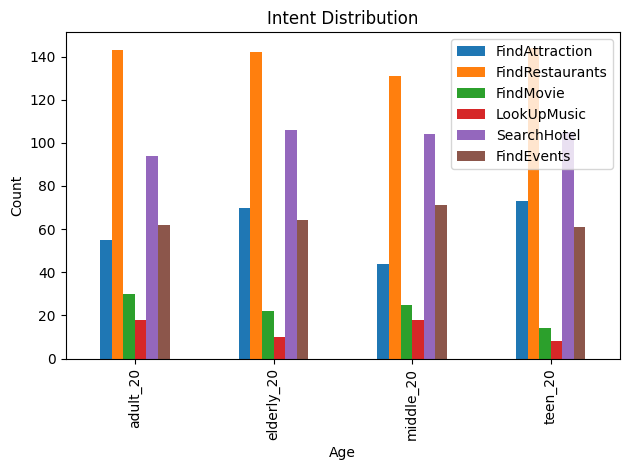

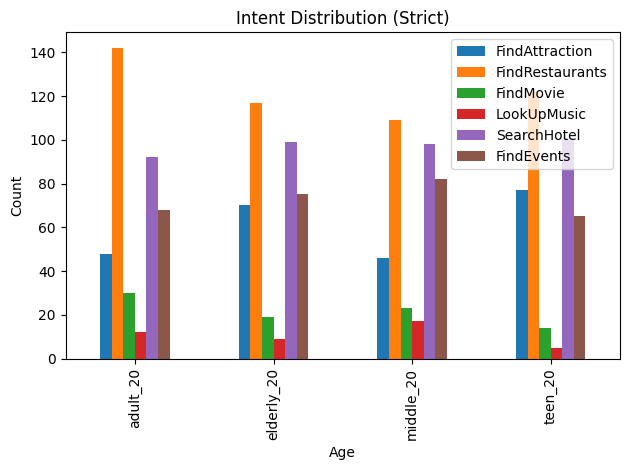

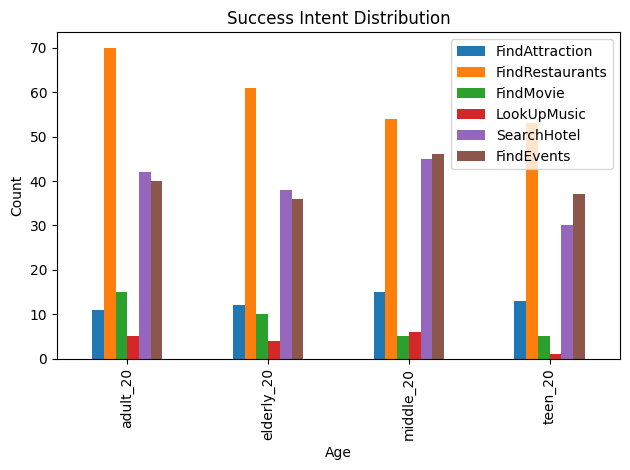

In [30]:
def plot_dist(df, title, xlabel, ylabel):
     df.plot(kind='bar')
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.legend()
     plt.tight_layout()
     plt.show()


df = age_agg_df.loc[:, pd.IndexSlice['intent count', :]]
df.columns = df.columns.droplevel(0)
plot_dist(df, title='Intent Distribution', xlabel='Age', ylabel='Count')

df = age_agg_df.loc[:, pd.IndexSlice['intent count strict', :]]
df.columns = df.columns.droplevel(0)
plot_dist(df, title='Intent Distribution (Strict)', xlabel='Age', ylabel='Count')

df = age_agg_df.loc[:, pd.IndexSlice['success intent count', :]]
df.columns = df.columns.droplevel(0)
plot_dist(df, title='Success Intent Distribution', xlabel='Age', ylabel='Count')

### ANOVA 

In [31]:
import itertools

df = age_df
cols = list(df.columns)
cols.remove(('age', ''))

ages = df['age'].unique()
results = []

for col in cols:
    # 全體 ANOVA
    groups = [group[col].values for name, group in df.groupby('age')]
    _, p_value = stats.f_oneway(*groups)
    results.append({
        'metric': col,
        'group': 'All ages',
        'p_value': round(p_value, 6)
    })

    # 任兩組之間的 ANOVA
    for sec1, sec2 in itertools.combinations(ages, 2):
        group1 = df[df['age'] == sec1][col].values
        group2 = df[df['age'] == sec2][col].values
        _, p_value = stats.f_oneway(group1, group2)
        results.append({
            'metric': col,
            'group': f'{sec1} vs {sec2}',
            'p_value': round(p_value, 6)
        })

anova_df = pd.DataFrame(results)

# 讓 All sections 排最前
anova_df['group'] = pd.Categorical(
    anova_df['group'],
    categories=['All ages'] + sorted(g for g in anova_df['group'].unique() if g != 'All ages'),
    ordered=True
)

anova_pivot = anova_df.pivot(index='group', columns='metric', values='p_value')
anova_pivot.title = 'ANOVA p-value'
anova_pivot.columns = pd.MultiIndex.from_tuples(anova_pivot.columns)
anova_pivot.to_csv('age_anova_pvalue.csv')

def highlight_significant(val):
    """將 p-value < 0.05 的 cell 標為淡紅色"""
    if pd.isna(val):
        return ''
    return 'background-color: #bbcccc' if val < 0.05 else ''

styled = anova_pivot.style.set_table_styles(
    [
        {
            'selector': 'th.col_heading',
            'props': 'border: 2px solid black;'
        }
    ]
).map(highlight_significant).format("{:.2f}").set_caption("ANOVA p-value")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(styled)

## Gender Result Analysis
- 20 (random) personas
- 15 conversations each

In [33]:
gender_result = []

for path in sorted(glob('/tmp2/b11902155/PersonSalesAgent/simulation_output/gender_20/*.json')):
     with open(path, 'r') as f:
          data = json.load(f)

     gender = Path(path).stem
     
     for p in data:
          success_rate = (sum(1 for reason in p['terminate_reason'] if reason == 'Success') /
                         len(p['terminate_reason']))
          average_turn = sum(x for x in p['num_turns']) / len(p['num_turns'])
          average_turn_w_success = np.mean([
               p['num_turns'][i]
               for i in range(len(p["num_turns"]))
               if p['terminate_reason'][i] == 'Success'
          ])
          continue_ratio_micro = (sum(1 for conv in p['conversations'].values() for c in conv if c['role'] == 'user' and 'I should continue the topic' in c.get('thought', '')) /
                                   sum(1 for conv in p['conversations'].values() for c in conv if c['role'] == 'user'))

          continue_ratio_macro = np.mean([
               sum(1 for c in conv if c['role'] == 'user' and 'I should continue the topic' in c.get('thought', '')) /
               sum(1 for c in conv if c['role'] == 'user')
               for conv in p['conversations'].values()
          ])

          intent_count = {intent: 0 for intent in INTENTS}
          intent_count_strict = {intent: 0 for intent in INTENTS}
          success_intent_count = {intent: 0 for intent in INTENTS}
          switch_count = 0
          switch_count_strict = 0
          switch_count_success = 0
          switch_count_strict_success = 0
          for i, conv in enumerate(p['conversations'].values()):
               success = p['terminate_reason'][i] == 'Success'
               switch_cnt_strict = 0
               last_intent = None
               last_intent_strict = None

               if success:
                    success_intent_count[find_intent(conv[-1]['thought'])] += 1
               
               for c in conv:
                    if c['role'] != 'user':
                         continue

                    intent = find_intent(c.get('thought', ''))
                    if c.get('thought', '').startswith('The user did not implicitly mention any potential intent, I should continue the chit-chat.'):
                         last_intent_strict = None
                    if intent is not None:
                         if last_intent is not None and intent != last_intent:
                              switch_count += 1
                              if success:
                                   switch_count_success += 1
                              intent_count[last_intent] += 1
                         last_intent = intent

                         if last_intent_strict is not None and intent != last_intent_strict:
                              switch_count_strict += 1
                              if success:
                                   switch_count_strict_success += 1
                              intent_count_strict[last_intent] += 1
                         last_intent_strict = intent
                         
               if last_intent is not None:
                    switch_count += 1
                    if success:
                         switch_count_success += 1
                    intent_count[last_intent] += 1
               if last_intent_strict is not None:
                    switch_count_strict += 1
                    if success:
                         switch_count_strict_success += 1
                    intent_count_strict[last_intent] += 1

          switch_count /= len(p['conversations'])
          switch_count_strict /= len(p['conversations'])
          switch_count_success /= sum(1 for msg in p['terminate_reason'] if msg == 'Success')
          switch_count_strict_success /= sum(1 for msg in p['terminate_reason'] if msg == 'Success')


          gender_result.append({
               'gender': gender,
               'success rate': success_rate,
               'average turn': average_turn,
               'average turn w/ success': average_turn_w_success,
               'continue ratio micro': continue_ratio_micro,
               'continue ratio macro': continue_ratio_macro,
               'switch count': switch_count,
               'switch count strict': switch_count_strict,
               'switch count w/ success': switch_count_success,
               'switch count w/ success strict': switch_count_strict_success,
          }| {
               ('intent count', k): v
               for k, v in intent_count.items()
          } | {
               ('intent count strict', k): v
               for k, v in intent_count_strict.items()
          } | {
               ('success intent count', k): v
               for k, v in success_intent_count.items()
          })

gender_df = pd.DataFrame.from_dict(gender_result)
gender_df.columns = pd.MultiIndex.from_tuples([
    (col, '') if not isinstance(col, tuple) else col for col in gender_df.columns
])
gender_df


gender success rate average turn average turn w/ success  \
                                                                  
0   female_20     0.800000    13.866667               12.333333   
1   female_20     0.466667    16.533333               12.571429   
2   female_20     0.533333    16.266667               13.000000   
3   female_20     0.466667    16.933333               13.428571   
4   female_20     0.600000    14.666667               11.111111   
5   female_20     0.600000    15.066667               11.777778   
6   female_20     0.733333    13.333333               10.909091   
7   female_20     0.533333    15.866667               12.250000   
8   female_20     0.666667    12.800000                9.200000   
9   female_20     0.200000    17.600000                8.000000   
10  female_20     0.533333    15.333333               11.250000   
11  female_20     0.333333    17.733333               13.200000   
12  female_20     0.533333    15.466667               11.500000   
13  female_20     0.266667    18.133333               13.000000   
14  female_20     0.333333    16.400000                9.200000   
15  female_20     0.466667    15.733333               10.857143   
16  female_20     0.333333    16.666667               10.000000   
17  female_20     0.600000    15.066667               11.777778   
18  female_20     0.666667    14.000000               11.000000   
19  female_20     0.266667    17.466667               10.500000   
20    male_20     0.866667    12.666667               11.538462   
21    male_20     0.533333    16.133333               12.750000   
22    male_20     0.800000    14.666667               13.333333   
23    male_20     0.733333    13.333333               10.909091   
24    male_20     0.533333    16.000000               12.500000   
25    male_20     0.666667    13.200000                9.800000   
26    male_20     0.533333    15.200000               11.000000   
27    male_20     0.333333    18.533333               15.600000   
28    male_20     0.733333    13.466667               11.090909   
29    male_20     0.533333    15.466667               11.500000   
30    male_20     0.600000    15.466667               12.444444   
31    male_20     0.333333    18.000000               14.000000   
32    male_20     0.733333    14.533333               12.545455   
33    male_20     0.733333    14.133333               12.000000   
34    male_20     0.533333    14.133333                9.000000   
35    male_20     0.533333    15.200000               11.250000   
36    male_20     0.400000    16.666667               11.666667   
37    male_20     0.466667    16.933333               13.428571   
38    male_20     0.600000    14.133333               10.222222   
39    male_20     0.266667    17.200000                9.500000   

   continue ratio micro continue ratio macro switch count switch count strict  \
                                                                                
0              0.327731             0.264923     1.466667            1.400000   
1              0.467626             0.411246     1.733333            1.733333   
2              0.481752             0.423670     1.333333            1.333333   
3              0.478873             0.438648     1.400000            1.333333   
4              0.328000             0.256039     1.333333            1.333333   
5              0.523438             0.458225     1.466667            1.466667   
6              0.356522             0.278110     1.200000            1.200000   
7              0.388060             0.329004     1.466667            1.400000   
8              0.450450             0.324242     1.333333            1.333333   
9              0.510204             0.459596     1.600000            1.600000   
10             0.500000             0.417689     1.000000            1.000000   
11             0.506757             0.457239     1.266667            1.133333   
12             0.488550             0.408434     1.333333 

In [36]:
agg_dict = {}
for col in gender_df.columns:
     if col[0] in ['gender']:
          continue
     if col[0] in ['intent count', 'intent count strict', 'success intent count']:
          agg_dict[col] = 'sum'
     else:
          agg_dict[col] = 'mean'

gender_agg_df = gender_df.groupby('gender', as_index=False).agg(agg_dict)
gender_agg_df.set_index('gender', inplace = True)
gender_agg_df.to_csv('gender_result.csv')

float_cols = age_df.select_dtypes(include='float').columns
format_dict = {col: "{:.2f}" for col in float_cols}

styled_gender_agg_df = (
     gender_agg_df.style
     .format(format_dict)
     .set_caption("Gender Aggregated Results")
     .set_table_styles(
          [
               {
                    'selector': 'th.col_heading',
                    'props': 'border: 2px solid black;'
               }
          ]
     )
)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
     display(styled_gender_agg_df)


### Plot


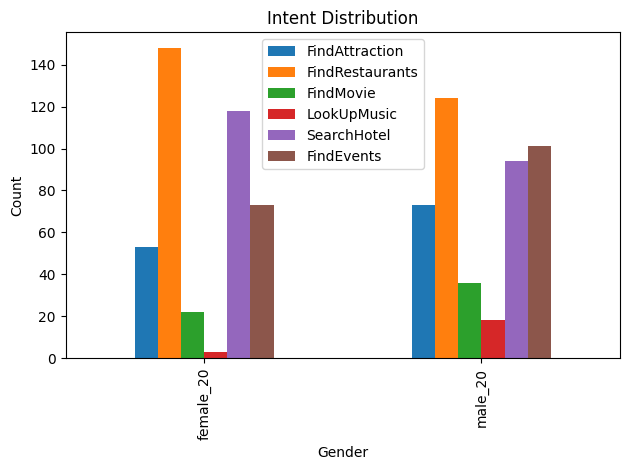

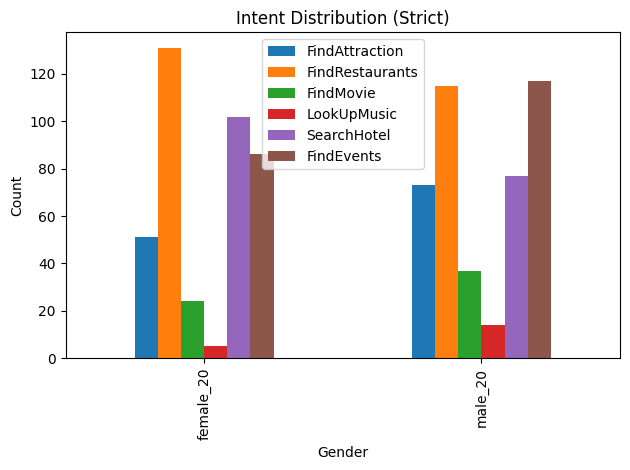

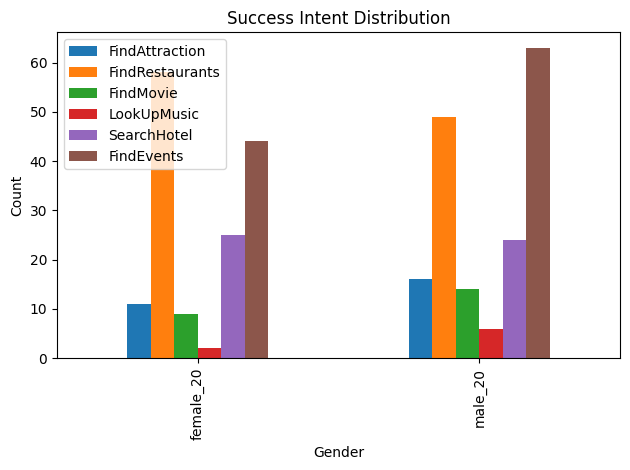

In [37]:
def plot_dist(df, title, xlabel, ylabel):
    df.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()


df = gender_agg_df.loc[:, pd.IndexSlice['intent count', :]]
df.columns = df.columns.droplevel(0)
plot_dist(df, title='Intent Distribution', xlabel='Gender', ylabel='Count')

df = gender_agg_df.loc[:, pd.IndexSlice['intent count strict', :]]
df.columns = df.columns.droplevel(0)
plot_dist(df, title='Intent Distribution (Strict)', xlabel='Gender', ylabel='Count')

df = gender_agg_df.loc[:, pd.IndexSlice['success intent count', :]]
df.columns = df.columns.droplevel(0)
plot_dist(df, title='Success Intent Distribution', xlabel='Gender', ylabel='Count')

### ANOVA (T-Test)

In [39]:
import itertools

df = gender_df
cols = list(df.columns)
cols.remove(('gender', ''))

ages = df['gender'].unique()
results = []

for col in cols:
    # 全體 ANOVA
    groups = [group[col].values for name, group in df.groupby('gender')]
    _, p_value = stats.f_oneway(*groups)
    results.append({
        'metric': col,
        'group': 'All genders',
        'p_value': round(p_value, 6)
    })

    # 任兩組之間的 ANOVA
    for sec1, sec2 in itertools.combinations(ages, 2):
        group1 = df[df['gender'] == sec1][col].values
        group2 = df[df['gender'] == sec2][col].values
        _, p_value = stats.f_oneway(group1, group2)
        results.append({
            'metric': col,
            'group': f'{sec1} vs {sec2}',
            'p_value': round(p_value, 6)
        })

anova_df = pd.DataFrame(results)

# 讓 All sections 排最前
anova_df['group'] = pd.Categorical(
    anova_df['group'],
    categories=['All genders'] + sorted(g for g in anova_df['group'].unique() if g != 'All genders'),
    ordered=True
)

anova_pivot = anova_df.pivot(index='group', columns='metric', values='p_value')
anova_pivot.title = 'ANOVA p-value'
anova_pivot.columns = pd.MultiIndex.from_tuples(anova_pivot.columns)
anova_pivot.to_csv('age_anova_pvalue.csv')

def highlight_significant(val):
    """將 p-value < 0.05 的 cell 標為淡紅色"""
    if pd.isna(val):
        return ''
    return 'background-color: #bbcccc' if val < 0.05 else ''

styled = anova_pivot.style.set_table_styles(
    [
        {
            'selector': 'th.col_heading',
            'props': 'border: 2px solid black;'
        }
    ]
).map(highlight_significant).format("{:.2f}").set_caption("ANOVA p-value")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(styled)